In [11]:
import pandas as pd
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../lrge_per_read_estimates.csv", low_memory=False)
df

,accession,method,estimate
0,SRR26337672,ava,1.079573e+07
1,SRR26337672,ava,1.144846e+07
2,SRR26337672,ava,1.034252e+07
3,SRR26337672,ava,1.127571e+07
4,SRR26337672,ava,9.544621e+06
...,...,...,...
95916014,DRR287515,2set,5.124770e+06
95916015,DRR287515,2set,3.641816e+06
95916016,DRR287515,2set,4.148180e+06
95916017,DRR287515,2set,2.859545e+06


In [3]:
samples = pd.read_csv("../results/estimates/estimates.tsv", sep="\t")
true_sizes = dict()
for _, row in samples.iterrows():
    true_sizes[row["run"]] = row["true_size"]

In [4]:
df['relative_size'] = df['estimate'] / df['accession'].map(true_sizes)

In [6]:
groups = df.groupby(["accession", "method"])

In [7]:
# function to apply to each group. it takes the median of the relative size and the median of the finite relative sizes
# it also calculates the percentiles of the relative sizes in 2.5% steps
def f(group):
    relsizes = group["relative_size"]
    median = relsizes.median()
    finite_ixs = np.isfinite(relsizes)
    finite = relsizes[finite_ixs]
    finite_median = finite.median()
    percentiles = np.percentile(relsizes, np.arange(2.5, 100, 2.5))
    finite_percentiles = np.percentile(finite, np.arange(2.5, 100, 2.5))
    return pd.Series([median, finite_median] + list(percentiles) + list(finite_percentiles))

In [8]:
medians_df = groups.apply(f)

/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/numpy/lib/function_base

In [9]:
medians_df.columns = ["median", "finite_median"] + [f"percentile_{x}" for x in np.arange(2.5, 100, 2.5)] + [f"finite_percentile_{x}" for x in np.arange(2.5, 100, 2.5)]
medians_df.to_csv("medians.csv")

In [10]:
medians_df

median  finite_median  percentile_2.5  percentile_5.0  \
accession  method                                                            
DRR072240  2set    2.205953       2.114013        0.950543        1.088166   
           ava     2.057436       2.057436        1.038549        1.180095   
DRR126367  2set    4.603692       4.234734        1.490992        1.852709   
           ava     4.196325       4.196325        1.918251        2.166099   
DRR126418  2set    3.996836       3.553474        0.801433        1.078254   
...                     ...            ...             ...             ...   
SRR9970116 ava     1.016976       1.016976        0.445367        0.541411   
SRR9970117 2set    1.014124       1.009299        0.299102        0.630138   
           ava     1.031338       1.031338        0.525995        0.686357   
SRR9988395 2set    2.916679       1.443319        0.680019        0.792151   
           ava     1.448346       1.448346        0.664069        0.778276   

                   percentile_7.5  percentile_10.0  percentile_12.5  \
accession  method                                                     
DRR072240  2set          1.187026         1.278246         1.348108   
           ava           1.264510         1.323000         1.378175   
DRR126367  2set          2.093078         2.271170         2.428232   
           ava           2.356292         2.500313         2.630052   
DRR126418  2set          1.325569         1.484475         1.608479   
...                           ...              ...              ...   
SRR9970116 ava           0.629437         0.703047         0.744685   
SRR9970117 2set          0.703314         0.744776         0.774822   
           ava           0.749743         0.786287         0.813383   
SRR9988395 2set          0.886226         0.976161         1.035053   
           ava           0.846477         0.904083         0.949917   

                   percentile_15.0  percentile_17.5  percentile_20.0  ...  \
accession  method                                                     ...   
DRR072240  2set           1.398926         1.460134         1.509590  ...   
           ava            1.425298         1.472269         1.515153  ...   
DRR126367  2set           2.577282         2.712279         2.842827  ...   
           ava            2.744896         2.853332         2.959587  ...   
DRR126418  2set           1.725127         1.841515         1.961439  ...   
...                            ...              ...              ...  ...   
SRR9970116 ava            0.772585         0.794841         0.816276  ...   
SRR9970117 2set           0.796976         0.817908         0.835401  ...   
           ava            0.838100         0.858288         0.875416  ...   
SRR9988395 2set           1.102154         1.174780         1.242292  ...   
           ava            0.992121         1.030643         1.064224  ...   

                   finite_percentile_75.0  finite_percentile_77.5  \
accession  method                                                   
DRR072240  2set                  3.161112                3.378205   
           ava                   3.071150                3.279121   
DRR126367  2set                  7.553057                8.530753   
           ava                   8.391807               10.246970   
DRR126418  2set                  7.858825                8.647565   
...                                   ...                     ...   
SRR9970116 ava                   1.209360                1.235860   
SRR9970117 2set                  1.200828                1.225483   
           ava                   1.188784                1.208414   
SRR9988395 2set                  1.998214                2.058265   
           ava                   1.877079                1.944183   

                   finite_percentile_80.0  finite_percentile_82.5  \
accession  method                                                   
DRR072240  2set                  3.629827   

In [ ]:
# melt data so that finite and all medians are in the same column with a column indicating which one it is
melted = medians_df.reset_index().melt(id_vars=["accession", "method"], value_vars=["median", "finite_median"], var_name="type", value_name="value")

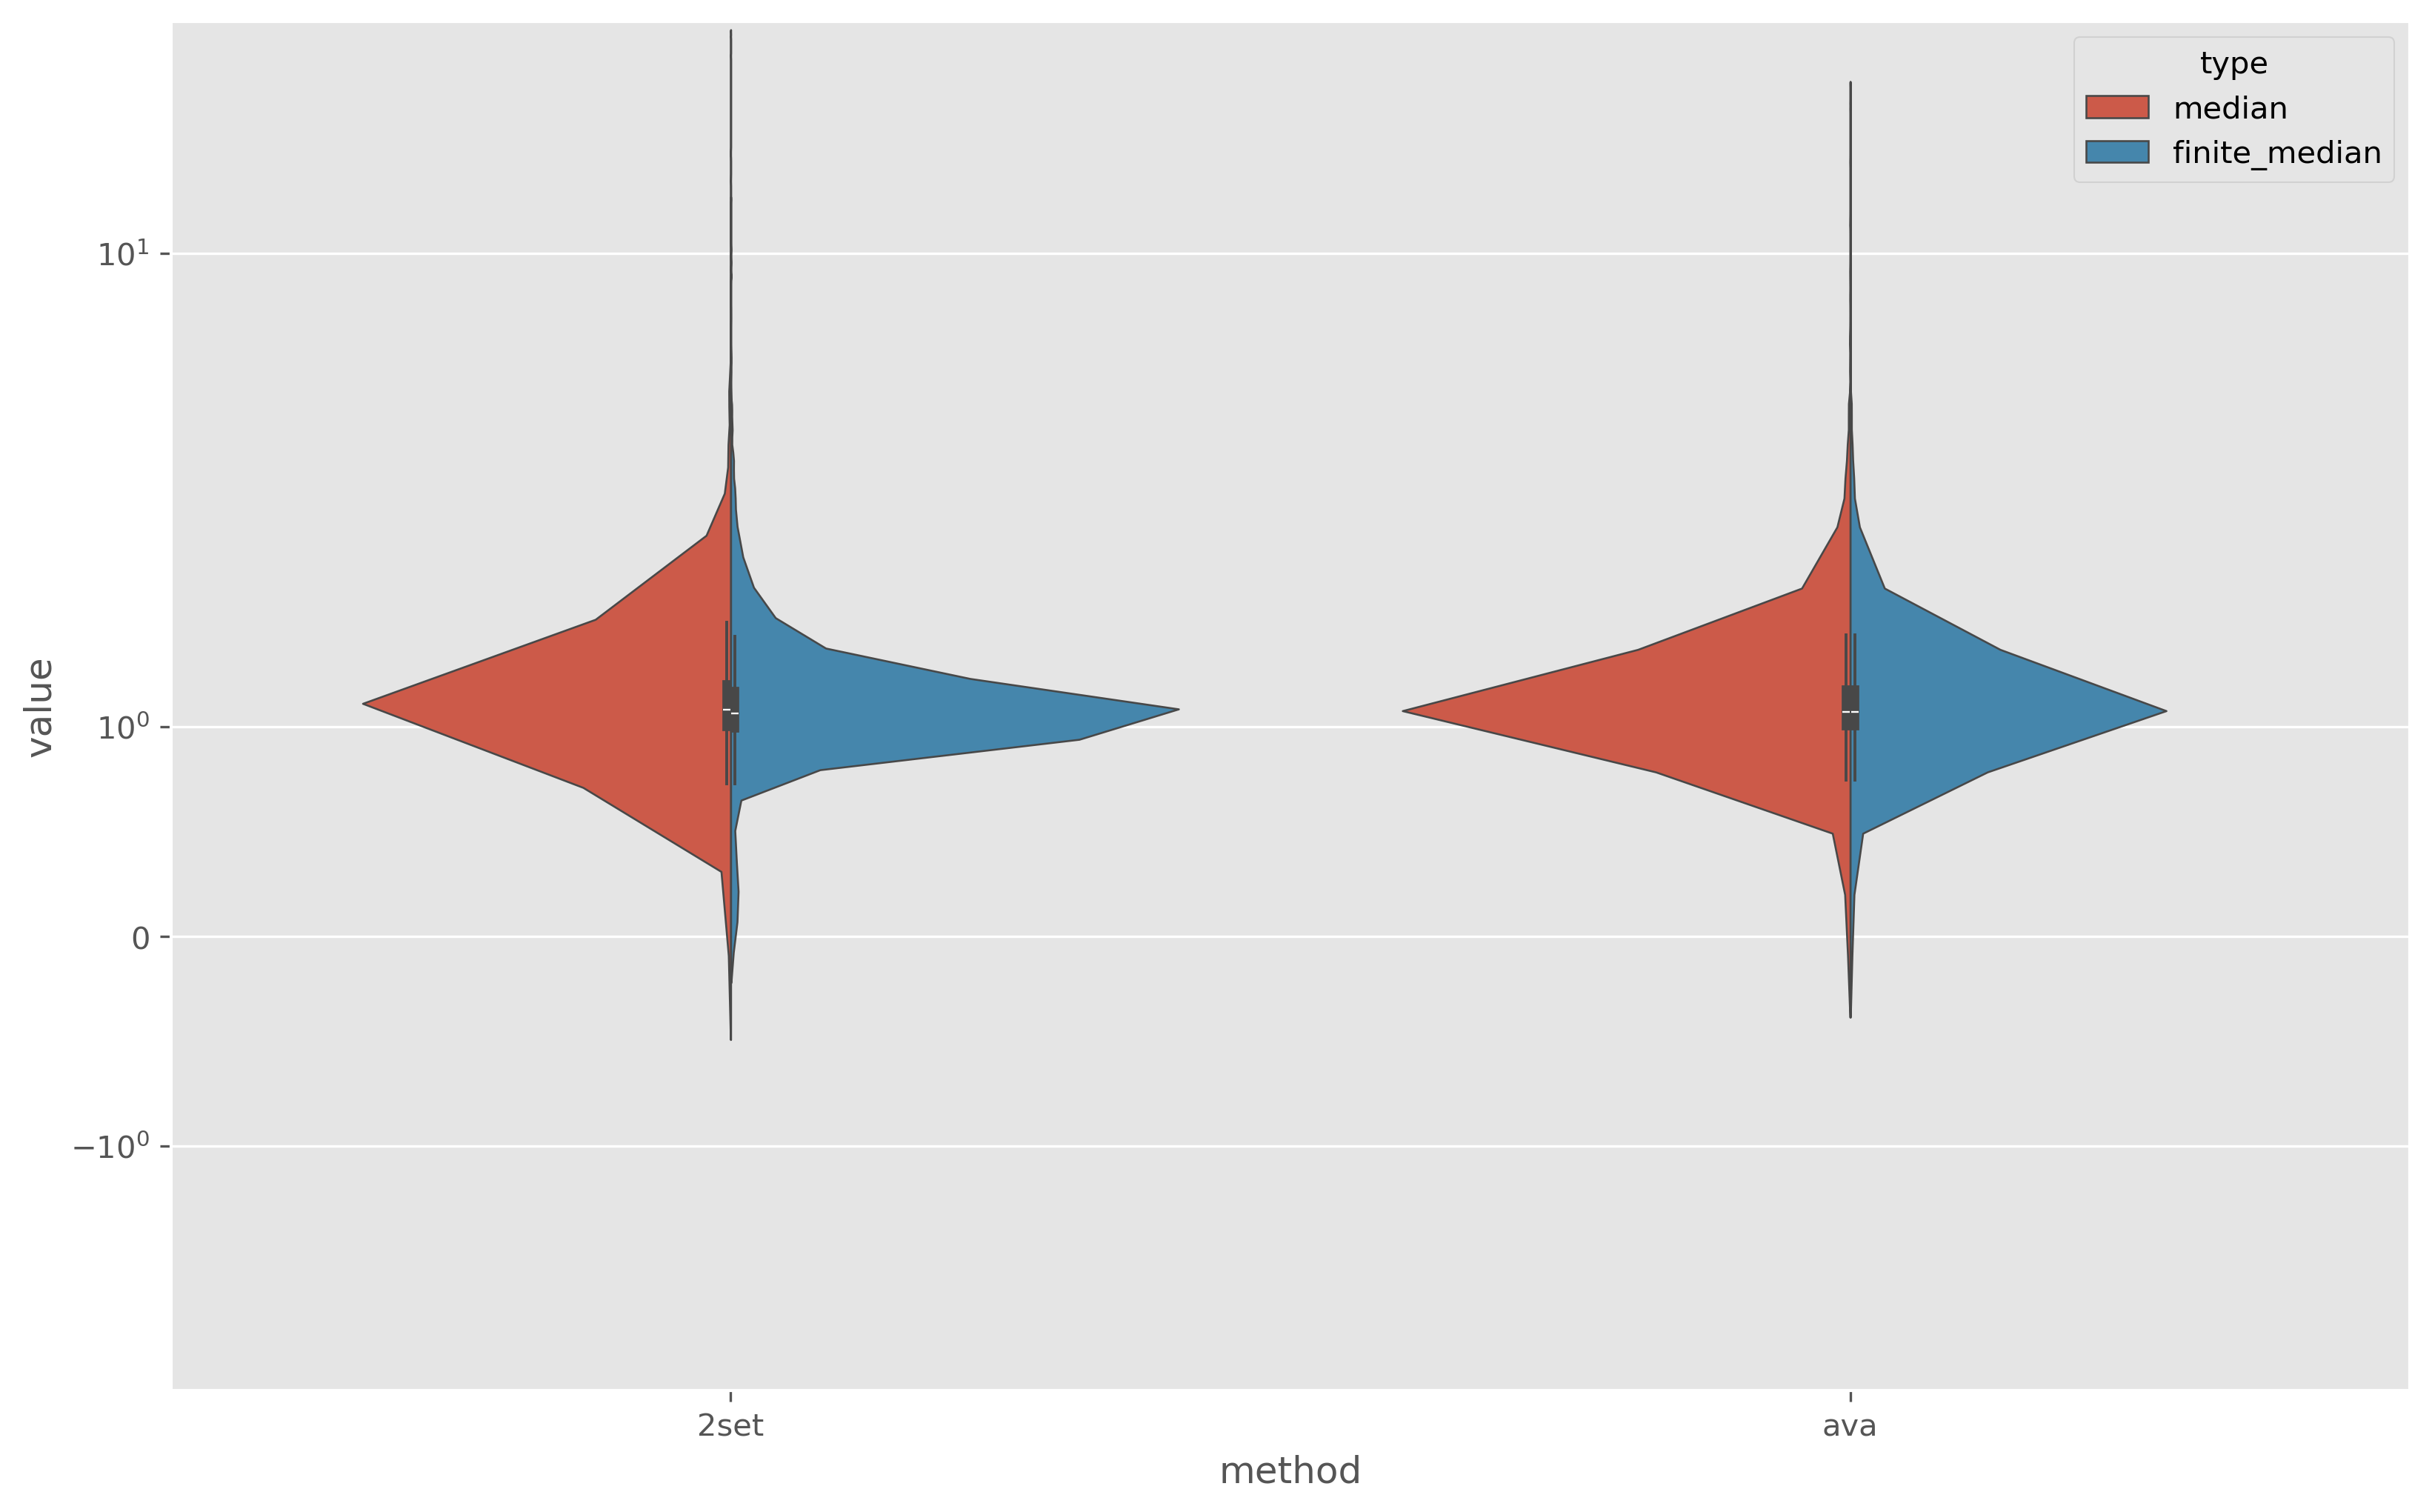

In [17]:
fig, ax = plt.subplots(dpi=300)

# sns.boxenplot(data=melted, x="method", y="value", hue="type", ax=ax)
sns.violinplot(data=melted, x="method", y="value", hue="type", ax=ax, split=True)
ax.set_yscale("symlog")

In [16]:
melted.groupby(["method", "type"]).describe()

/home/michael/sw/miniforge3/envs/lrge/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


value                                          \
                       count      mean       std       min       25%   
method type                                                            
2set   finite_median  3465.0  1.155490  0.568976  0.002234  0.993529   
       median         3465.0       inf       NaN  0.002234  1.004253   
ava    finite_median  3465.0  1.209259  1.012929  0.011601  1.005271   
       median         3465.0  1.209259  1.012929  0.011601  1.005271   

                                                     
                           50%       75%        max  
method type                                          
2set   finite_median  1.062897  1.169746  13.920254  
       median         1.085356  1.220623        inf  
ava    finite_median  1.070860  1.178180  28.164442  
       median         1.070860  1.178180  28.164442

In [12]:
# show where medians are different
medians_df[medians_df["median"] != medians_df["finite_median"]]

,,median,finite_median,percentile_2.5,percentile_5.0,percentile_7.5,percentile_10.0,percentile_12.5,percentile_15.0,percentile_17.5,percentile_20.0,...,finite_percentile_75.0,finite_percentile_77.5,finite_percentile_80.0,finite_percentile_82.5,finite_percentile_85.0,finite_percentile_87.5,finite_percentile_90.0,finite_percentile_92.5,finite_percentile_95.0,finite_percentile_97.5
accession,method,,,,,,,,,,,,,,,,,,,,,
DRR072240,2set,2.205953,2.114013,0.950543,1.088166,1.187026,1.278246,1.348108,1.398926,1.460134,1.509590,...,3.161112,3.378205,3.629827,3.929384,4.282197,4.790821,5.679067,7.072960,10.296089,18.895478
DRR126367,2set,4.603692,4.234734,1.490992,1.852709,2.093078,2.271170,2.428232,2.577282,2.712279,2.842827,...,7.553057,8.530753,9.767207,11.356116,13.486681,16.423281,20.029623,23.651747,30.410502,39.640542
DRR126418,2set,3.996836,3.553474,0.801433,1.078254,1.325569,1.484475,1.608479,1.725127,1.841515,1.961439,...,7.858825,8.647565,9.881056,11.143004,12.797672,14.773303,18.013552,22.662734,27.379001,35.115639
DRR126420,2set,4.118922,3.817887,0.936286,1.329816,1.566461,1.719402,1.851204,1.978698,2.100755,2.236339,...,6.284926,6.795098,7.414811,8.190184,9.104439,10.960639,12.889729,16.360204,23.057184,30.838410
DRR140496,2set,1.853989,1.698482,0.446683,0.636323,0.844200,0.981288,1.066993,1.139565,1.197493,1.249091,...,2.374262,2.505015,2.688774,2.865905,3.157563,3.503286,3.986727,4.706029,6.242208,11.111024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9900640,2set,1.700330,1.465656,0.557416,0.684710,0.767150,0.834180,0.892937,0.934093,0.988293,1.039868,...,2.137918,2.300387,2.499247,2.916751,3.356690,3.458015,3.577416,3.757529,4.057467,4.660531
SRR9901958,2set,1.316152,1.259790,0.337257,0.473974,0.549280,0.622813,0.687344,0.749841,0.811766,0.861338,...,1.716464,1.798801,1.932481,2.000018,2.130370,2.448517,2.616629,3.325420,4.894798,9.678567
SRR9970116,2set,1.012217,1.006146,0.222938,0.352214,0.460456,0.594210,0.664197,0.705026,0.743646,0.775313,...,1.212310,1.239191,1.271971,1.304227,1.349336,1.402790,1.469200,1.563263,1.722884,2.006931


In [24]:
data = []
percentile_bins = [5, 10, 20, 30, 40, 50]
for percentile in percentile_bins:
    low_percentile = float(50 - percentile / 2)
    high_percentile = float(50 + percentile / 2)
    for (acc, method), row in medians_df.iterrows():
        low_val = row[f"percentile_{low_percentile}"]
        low_finite_val = row[f"finite_percentile_{low_percentile}"]
        high_val = row[f"percentile_{high_percentile}"]
        high_finite_val = row[f"finite_percentile_{high_percentile}"]
        all_contains_one = low_val <= 1.0 <= high_val
        finite_contains_one = low_finite_val <= 1.0 <= high_finite_val
        data.append([acc, method, percentile, low_percentile, high_percentile, 'all', low_val, high_val, all_contains_one])
        data.append([acc, method, percentile, low_percentile, high_percentile, 'finite', low_finite_val, high_finite_val, finite_contains_one])


In [25]:
percentile_df = pd.DataFrame(data, columns=["accession", "method", "percentile_bin", "low_percentile", "high_percentile", "type", "low", "high", "contains_one"])
percentile_df

,accession,method,percentile_bin,low_percentile,high_percentile,type,low,high,contains_one
0,DRR072240,2set,5,47.5,52.5,all,2.132013,2.270413,False
1,DRR072240,2set,5,47.5,52.5,finite,2.053574,2.173817,False
2,DRR072240,ava,5,47.5,52.5,all,2.000375,2.117135,False
3,DRR072240,ava,5,47.5,52.5,finite,2.000375,2.117135,False
4,DRR126367,2set,5,47.5,52.5,all,4.394310,4.793086,False
...,...,...,...,...,...,...,...,...,...
83155,SRR9970117,ava,50,25.0,75.0,finite,0.903158,1.188784,True
83156,SRR9988395,2set,50,25.0,75.0,all,1.365293,NaN,False
83157,SRR9988395,2set,50,25.0,75.0,finite,1.069052,1.998214,False
83158,SRR9988395,ava,50,25.0,75.0,all,1.128648,1.877079,False


/tmp/ipykernel_544133/3125837116.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


[Text(0, 0, '47.5-52.5'),
 Text(1, 0, '45-55'),
 Text(2, 0, '40-60'),
 Text(3, 0, '35-65'),
 Text(4, 0, '30-70'),
 Text(5, 0, '25-75')]

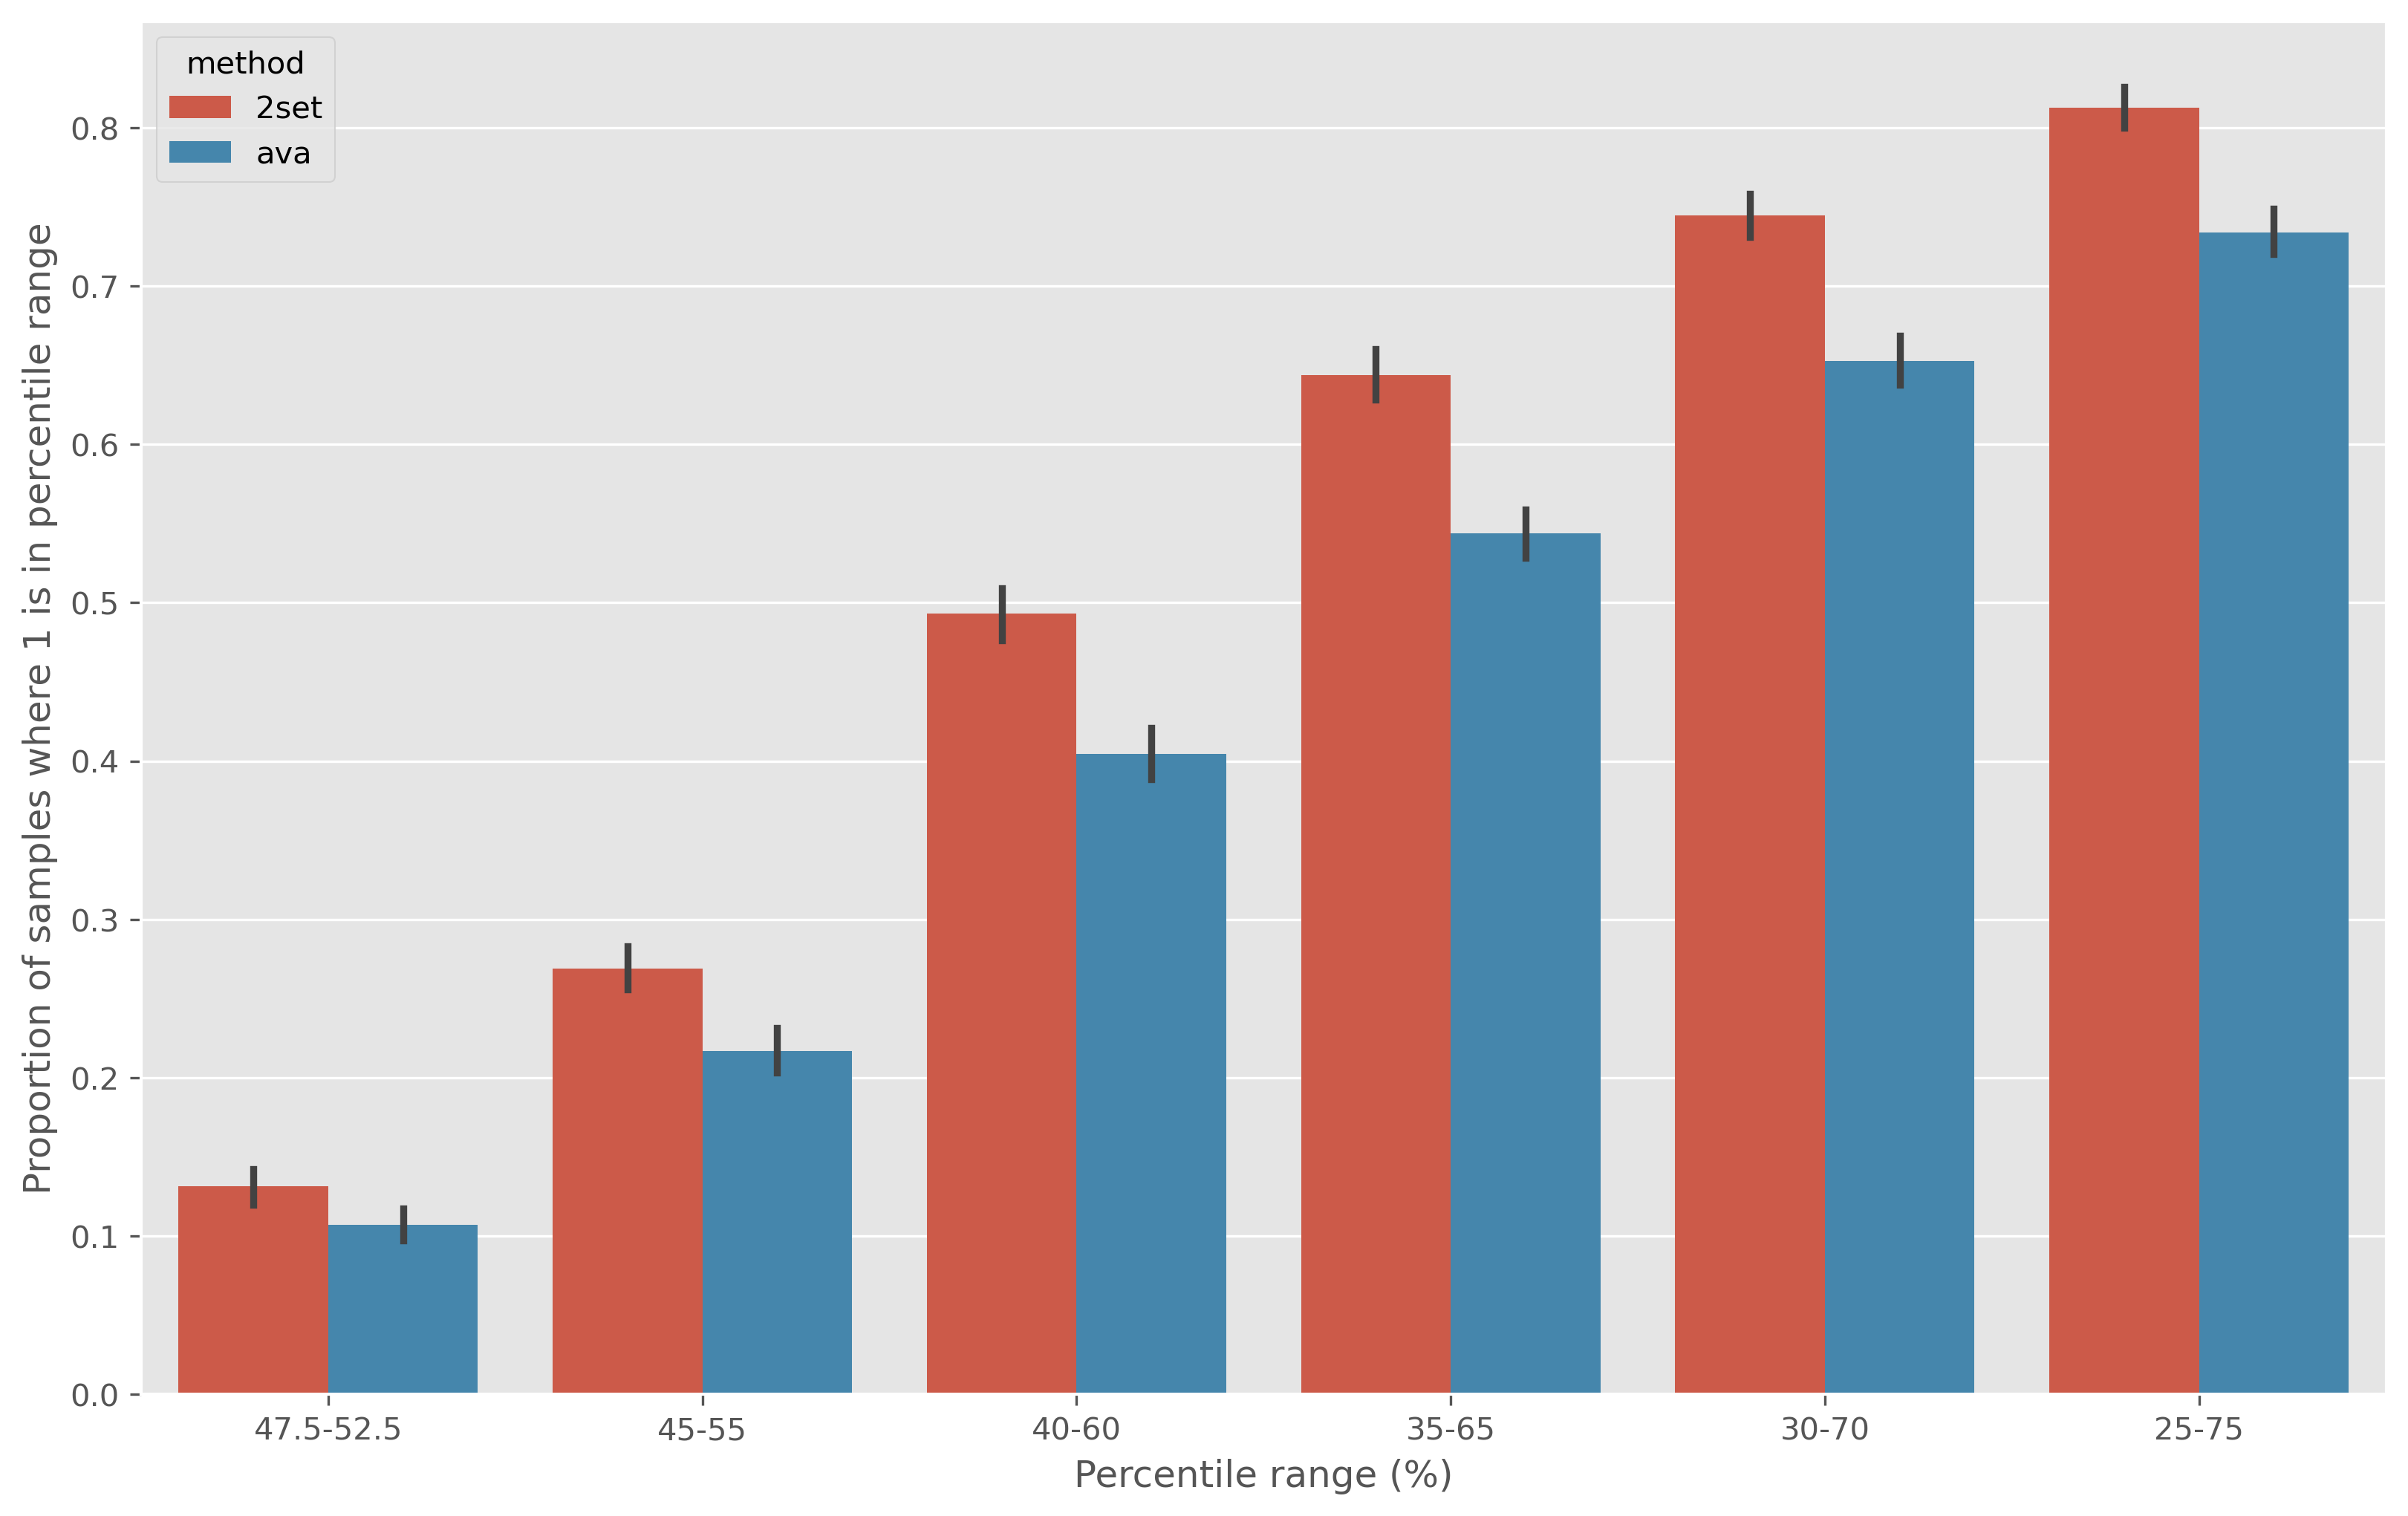

In [46]:
# on the xaxis, we plot the percentile bins, on the yaxis we plot the proportion of samples with True in the contains_one column
# and we hue on the method
d = percentile_df.query("type == 'finite'")
fig, ax = plt.subplots(dpi=300)
sns.barplot(data=d, x="percentile_bin", y="contains_one", hue="method", ax=ax)
ax.set_ylabel("Proportion of samples where 1 is in percentile range")
ax.set_xlabel("Percentile range (%)")
xticks = percentile_bins
xticklabels = [f"{50 - p / 2:g}-{50 + p / 2:g}" for p in percentile_bins]
# ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

In [32]:
ones = d.query("method == '2set' and percentile_bin == 5")["contains_one"]
sum(ones) / len(ones)

0.13131313131313133

In [37]:
xticks

[5, 10, 20, 30, 40, 50]

In [45]:
f"{3.50:g}"

'3.5'